# Assignment 5 Solution

This assignment is collaborated by **Jingting Dai** and **Hongjie Guan**. **Hongjie finished A05.1 and Jingting finished A05.2 and A05.3** 

## A05.1 Everyday networks are not Poisson: parameter estimation and model selection

Task: For all given networks compute the degree
distribution 𝑃(𝑘) and the average degree ⟨𝑘⟩ and use the
powerlaw package to fit 𝑃(𝑘).

### 1. Compute the power-law exponent 𝛾 of the degree distribution 𝑃(𝑘) ∼ 𝑘−𝛾 and the corresponding error

In [1]:
import networkx as nx
import scipy.stats as sp
from scipy.special import factorial
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import powerlaw
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['figure.figsize'] = (12, 6)

In [2]:
def import_datasets(datasets_folder):
    d={} #empty dictionary
    for item in os.listdir(datasets_folder):
        if 'gml'in item and 'random' not in item:
            item_path = os.path.join(datasets_folder,item)
            item_name = item.split("_",1)[1].split(".")[0] 
            print("dataset named "+item_name+" imported")
            d["{}".format(item_name)] = nx.read_gml(item_path)
    print("finish importing")
    return d

In [3]:
graphs = import_datasets('data-assignment5')
graphs

dataset named internet imported
dataset named amazon imported
dataset named escort imported
finish importing


{'internet': <networkx.classes.graph.Graph at 0x103e265f0>,
 'amazon': <networkx.classes.graph.Graph at 0x103e278e0>,
 'escort': <networkx.classes.graph.Graph at 0x125d935b0>}

In [4]:
# compute degree distribution
def compute_degree_distribution(graphs:dict)->dict:
    dd={}
    for k,v in graphs.items():
        degress = v.degree()
        dd[k]=[ degress[i] for i in v.nodes() ]
    return dd
 
    
# compute average degree<k>
def compute_average_degree(degree_distribution:dict)->dict:
    avg_ks={}
    for k,v in degree_distribution.items():
        avg_k = sum(v)/len(v)
        avg_ks[k]=avg_k
    return avg_ks

In [5]:
degree_distribution = compute_degree_distribution(graphs)
avg_ks = compute_average_degree(degree_distribution)
print("The average degree <k> of the given graphs are:")
avg_ks

The average degree <k> of the given graphs are:


{'internet': 6.197750352406432,
 'amazon': 5.529855493141971,
 'escort': 4.667543335325762}

In [6]:
def compute_gamma_and_error(degree_distribution:dict)->dict:
    gamma_and_error={}
    for k,v in degree_distribution.items():
        result = powerlaw.Fit(np.sort(np.asarray(v)))
        gamma = result.power_law.alpha
        sigma = result.power_law.sigma
        gamma_and_error[k]=(gamma,sigma)
    return gamma_and_error

gamma_and_error=compute_gamma_and_error(degree_distribution)
print("\nThe (gamma. sigma) tuples for each of the datasets are:")
gamma_and_error

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 99%
The (gamma. sigma) tuples for each of the datasets are:


{'internet': (2.112191339113011, 0.0366878070312722),
 'amazon': (4.065660034466614, 0.09699319113242895),
 'escort': (2.9544249080995764, 0.07919729392592209)}

### 2. In the same plot show: the empirical degree distribution; the power-law fit; the Poisson fit and the exponential distribution with mean value equal to ⟨𝑘⟩. Which distribution is more likely to describe the data?


In [7]:
def plot_data_with_multiple_fit(degree_distribution:dict,dataset_name:str,scale:str):
    k_list=degree_distribution[dataset_name]
    # plot empirical data
    l=len(k_list)
    k_unique=np.unique(np.asarray(k_list))
    P_k = [k_list.count(k)/l for k in k_unique]
    plt.scatter(k_unique,P_k,s=4,label="empirical")
    # plot powerlaw fit
    k_list = np.sort(np.array(degree_distribution[dataset_name]))
    result = powerlaw.Fit(k_list,xmin=min(k_list))
    powerlaw.plot_pdf(k_list,color='b',marker="o",label="empirical[2]")
    result.power_law.plot_pdf(color='r',label="power-law")

    
    # compute <k> as lamda
    lamda = sum(degree_distribution[dataset_name])/len(degree_distribution[dataset_name])
    
    # plot Possion distribution
    P_k_possion=[(pow(lamda,k)/factorial(k))*np.exp(-lamda) for k in k_unique]
    plt.plot(k_unique,P_k_possion,color='green',label="Poisson")
    # plot exponential distribution
    P_k_possion=[(np.exp(-(k/lamda))/lamda) for k in k_unique]
    plt.plot(k_unique,P_k_possion,color='yellow',label="exponential")
    
    plt.xscale(scale)
    plt.yscale(scale)
    plt.ylim([0.001*min(P_k), 1.5*max(P_k)])
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend(loc='best')
    plt.title("Degree distribution of {}".format(dataset_name))

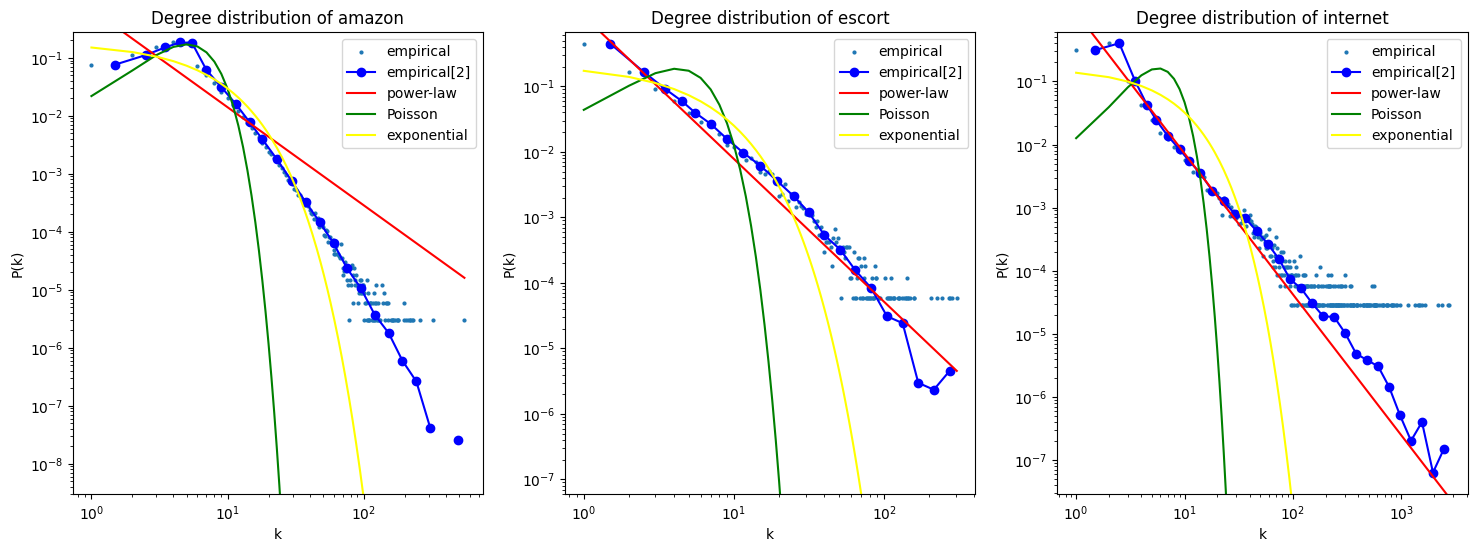

The empirical[2] distribution is generated by the powerlaw library.


In [8]:
matplotlib.rcParams['figure.figsize'] = (18, 6)
plt.subplot(1, 3, 1)
plot_data_with_multiple_fit(degree_distribution,'amazon','log')
plt.subplot(1, 3, 2)
plot_data_with_multiple_fit(degree_distribution,'escort','log')
plt.subplot(1, 3, 3)
plot_data_with_multiple_fit(degree_distribution,'internet','log')

plt.show()
print("The empirical[2] distribution is generated by the powerlaw library.")

We can tell that, obviously, the power-law can fit the best to escort and internet networks, exponential law fit better to Amazon network. The slope of the line is very close to the slope of distribution.

### 3. What does it mean in practice for Amazon products?

The distribution of co-sale products of Amazon are close to but not totally scale-free. If the distribution is scale-free(fit best by power law distritbution), it means that there is no pivot or the mean of co-sales where other co-sales number hover around(or the standard error is very large), which means that those Amazon products that sales with a lots of other products are really rare and those products that seldom sold with other products are very common.
However, we found that around $k=10^{0.7}$, the P(k) appears to be maximized, which is better fit to exponential law. This shows that there are some products that co-saled by $10^{0.7}$ other products, are more prequently pruchased. Amazon could look into these products.

## A05.2 Barabási-Albert model

Task: Build networks with the Barabási-Albert model.Connect 𝑚 = 3 for each new node and grow until 𝑁 = 50, 100, 500, 1000, 5000.

In [9]:
N = [50, 100, 500, 1000, 5000]

In [10]:
d_ba = {}
for i in N:
    g_i = nx.barabasi_albert_graph(i,3)
    d_ba[i] = g_i
d_ba

{50: <networkx.classes.graph.Graph at 0x13780d120>,
 100: <networkx.classes.graph.Graph at 0x13780d360>,
 500: <networkx.classes.graph.Graph at 0x13780f310>,
 1000: <networkx.classes.graph.Graph at 0x13780fa00>,
 5000: <networkx.classes.graph.Graph at 0x135b374f0>}

### 1. Compute the average clustering coefficient, assortativity, average shortest path length and diameter for the generated networks

In [11]:
clustering = {}
for name, graph in d_ba.items():
    avg_clustering = nx.average_clustering(graph)
    clustering[name] = avg_clustering
clustering

{50: 0.17628551857499228,
 100: 0.15185554435689977,
 500: 0.057126459788989295,
 1000: 0.026121266353244535,
 5000: 0.009324064873396263}

In [12]:
assortativity = {}
for name, graph in d_ba.items():
    avg_assortativity = nx.degree_assortativity_coefficient(graph)
    assortativity[name] = avg_assortativity
assortativity

{50: -0.20735159495810127,
 100: -0.19870256440526216,
 500: -0.10415691572039291,
 1000: -0.05955081284412129,
 5000: -0.04633410252879376}

In [13]:
shortest_path = {}
for name, graph in d_ba.items():
    avg_shortest_path = nx.average_shortest_path_length(graph)
    shortest_path[name] = avg_shortest_path
shortest_path

{50: 2.290612244897959,
 100: 2.5090909090909093,
 500: 3.193074148296593,
 1000: 3.5394174174174173,
 5000: 4.037692898579716}

In [14]:
diameter = {}
for name, graph in d_ba.items():
    dia = nx.diameter(graph)
    diameter[name] = dia
diameter

{50: 4, 100: 4, 500: 6, 1000: 6, 5000: 7}

### 2. Produce randomised versions of the same networks and calculate the same quantities, then plot them as functions of 𝑁 and compare with the non-randomised ones (use log x axis)

In [15]:
def randomise(networks):
    d_rnd={}
    for i in networks:
        d_rnd["grnd_{0}".format(i)] = nx.algorithms.smallworld.random_reference(
            networks[i],niter = 20, connectivity=False)
    return d_rnd

rnd_ba = randomise(d_ba)

In [16]:
rnd_clustering = {}
for name, graph in rnd_ba.items():
    avg_clustering_rnd = nx.average_clustering(graph)
    rnd_clustering[name] = avg_clustering_rnd
rnd_clustering

{'grnd_50': 0.18166017608122878,
 'grnd_100': 0.1925021851843336,
 'grnd_500': 0.05332954205747055,
 'grnd_1000': 0.025711227135918845,
 'grnd_5000': 0.00838334877992258}

In [17]:
rnd_assortativity = {}
for name, graph in rnd_ba.items():
    avg_assortativity_rnd = nx.degree_assortativity_coefficient(graph)
    rnd_assortativity[name] = avg_assortativity_rnd
rnd_assortativity

{'grnd_50': -0.11004858812759634,
 'grnd_100': -0.17520991976952857,
 'grnd_500': -0.0727603227102397,
 'grnd_1000': -0.05230600405454789,
 'grnd_5000': -0.026296154575730944}

In [18]:
rnd_shortest_path = {}
for name, graph in rnd_ba.items():
    avg_shortest_path_rnd = nx.average_shortest_path_length(graph)
    rnd_shortest_path[name] = avg_shortest_path_rnd
rnd_shortest_path

{'grnd_50': 2.3444897959183675,
 'grnd_100': 2.5725252525252524,
 'grnd_500': 3.267615230460922,
 'grnd_1000': 3.5935915915915917,
 'grnd_5000': 4.094444888977796}

In [19]:
rnd_diameter = {}
for name, graph in rnd_ba.items():
    dia_rnd = nx.diameter(graph)
    rnd_diameter[name] = dia_rnd
rnd_diameter

{'grnd_50': 4, 'grnd_100': 4, 'grnd_500': 6, 'grnd_1000': 6, 'grnd_5000': 7}

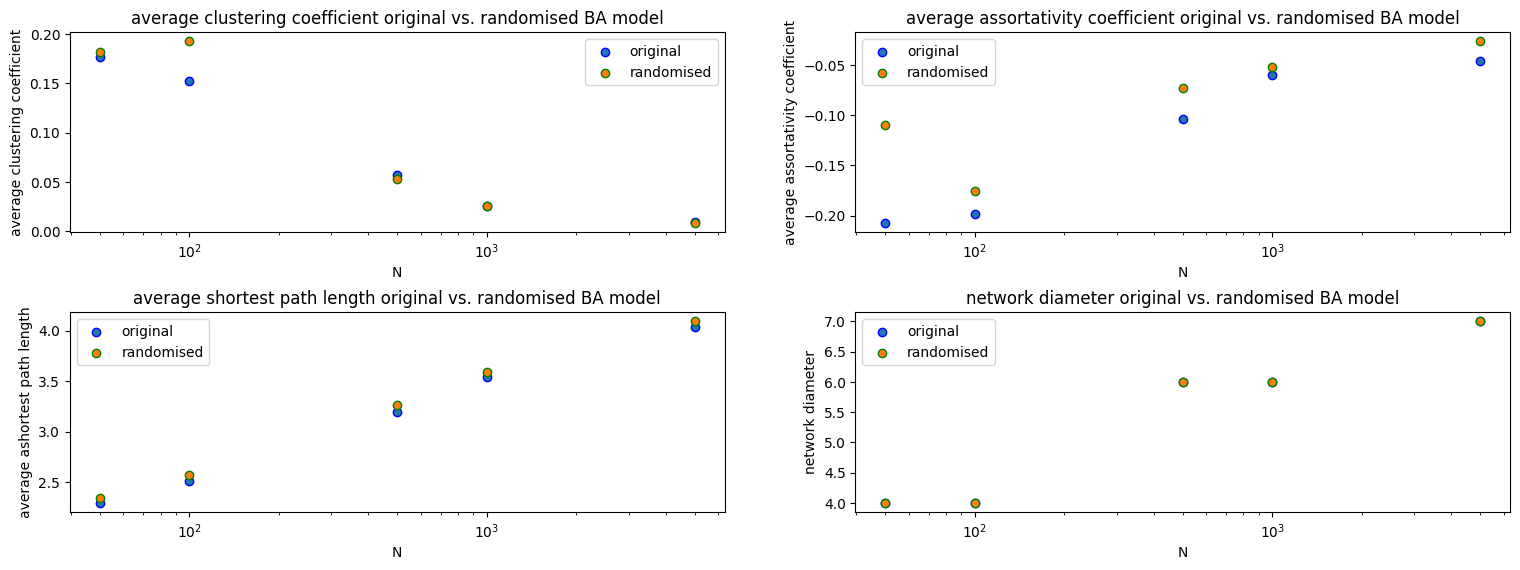

In [20]:
plt.subplot(2,2,1)
plt.scatter(N, clustering.values(), edgecolors="blue" ,label="original")
plt.scatter(N, rnd_clustering.values(), edgecolors="green" ,label="randomised")
plt.title("average clustering coefficient original vs. randomised BA model")
plt.xlabel('N')
plt.ylabel('average clustering coefficient')
plt.xscale('log')
plt.yscale('linear')
plt.legend(loc="best")

plt.subplot(2,2,2)
plt.scatter(N, assortativity.values(), edgecolors="blue" ,label="original")
plt.scatter(N, rnd_assortativity.values(), edgecolors="green" ,label="randomised")
plt.title("average assortativity coefficient original vs. randomised BA model")
plt.xlabel('N')
plt.ylabel('average assortativity coefficient')
plt.xscale('log')
plt.yscale('linear')
plt.legend(loc="best")

plt.subplot(2,2,3)
plt.scatter(N, shortest_path.values(), edgecolors="blue" ,label="original")
plt.scatter(N, rnd_shortest_path.values(), edgecolors="green" ,label="randomised")
plt.title("average shortest path length original vs. randomised BA model")
plt.xlabel('N')
plt.ylabel('average ashortest path length')
plt.xscale('log')
plt.yscale('linear')
plt.legend(loc="best")

plt.subplot(2,2,4)
plt.scatter(N, diameter.values(), edgecolors="blue" ,label="original")
plt.scatter(N, rnd_diameter.values(), edgecolors="green" ,label="randomised")
plt.title("network diameter original vs. randomised BA model")
plt.xlabel('N')
plt.ylabel('network diameter')
plt.xscale('log')
plt.yscale('linear')
plt.legend(loc="best")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)
plt.show()

### 3. Which of these measures is relatively unchanged by randomisation? Why?

The clustering coefficient and the average shortest path length is relatively unchanged.

Barabási-Albert model generates random scale-free networks that contains hubs with nodes of unusual high degree compared to other nodes. The average culstering coefficient checks if edges appear more densely in parts of the network. The average clustering coefficient of Barabási-Albert model follows $⟨C⟩$∼$(lnN)^{2}$/$N$, it is different from the $1/N$ dependence obtained for the random network model. in this case the $N$ is relatively small, the clustering coefficient has small difference.

The average path length of a graph is the average shortest path between all connected nodes. By degree-preserving randomisation, the number of edges are unchanged, and the high degree nodes preserves the property, so the average path length is relatively unchanged.

## A05.3 Barabási-Albert model (2)


Task: Build networks of 𝑁 = 500 nodes with the BA model,
varying the number of new connections 𝑚 ∈ {2, 3, 4, 5}.

In [21]:
m2 = [2, 3, 4, 5]

In [22]:
d_ba2 = {}
for i in m2:
    g_i = nx.barabasi_albert_graph(500,i)
    d_ba2[i] = g_i
d_ba2

{2: <networkx.classes.graph.Graph at 0x14612c2b0>,
 3: <networkx.classes.graph.Graph at 0x14647b3a0>,
 4: <networkx.classes.graph.Graph at 0x29ba20f10>,
 5: <networkx.classes.graph.Graph at 0x14612c6d0>}

### 1. Plot the degree distributions of the resulting networks

In [23]:
degree_distribution_ba = compute_degree_distribution(d_ba2)

In [24]:
def plot_degree_distribution(degree_distribution:dict,dataset_name:str,scale:str):   
    k_list=degree_distribution[dataset_name]
    # plot empirical data
    l=len(k_list)
    k_unique=np.unique(np.asarray(k_list))
    P_k = [k_list.count(k)/l for k in k_unique]
    plt.scatter(k_unique,P_k,s=4,label="empirical")
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.legend(loc='best')
    plt.title("Degree distribution of Barabási-Albert model m = {}".format(dataset_name))  

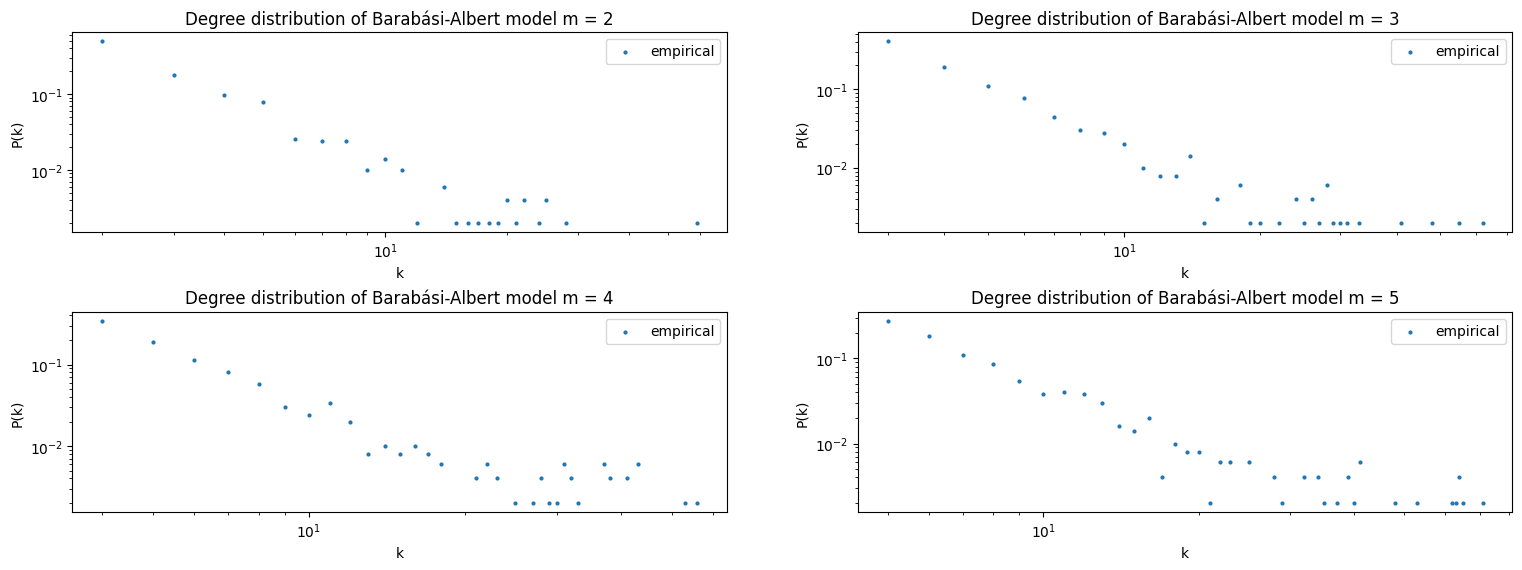

In [25]:
plt.subplot(2,2,1)
plot_degree_distribution(degree_distribution_ba,2,"log")

plt.subplot(2,2,2)
plot_degree_distribution(degree_distribution_ba,3,"log")

plt.subplot(2,2,3)
plot_degree_distribution(degree_distribution_ba,4,"log")

plt.subplot(2,2,4)
plot_degree_distribution(degree_distribution_ba,5,"log")

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

plt.show()

### 2. Estimate the power-law fit parameters

In [26]:
def find_alpha(degree_distribution:dict,dataset_name:str):
    k_list = np.sort(np.array(degree_distribution[dataset_name]))
    result = powerlaw.Fit(k_list,xmin=min(k_list))
    alpha = result.power_law.alpha
    return alpha

In [27]:
alpha_list = []
for i in degree_distribution_ba.keys():
    alpha = find_alpha(degree_distribution_ba,i)
    alpha_list.append(alpha)

print(alpha_list)

[3.241380394259398, 3.1891181945244105, 3.1225795751093157, 3.05730489796293]


$\alpha$ generated by nx.barabasi_albert_graph should be close to 3, which is true.

### 3. Plot the power-law exponent 𝛼 as a function of 𝑚

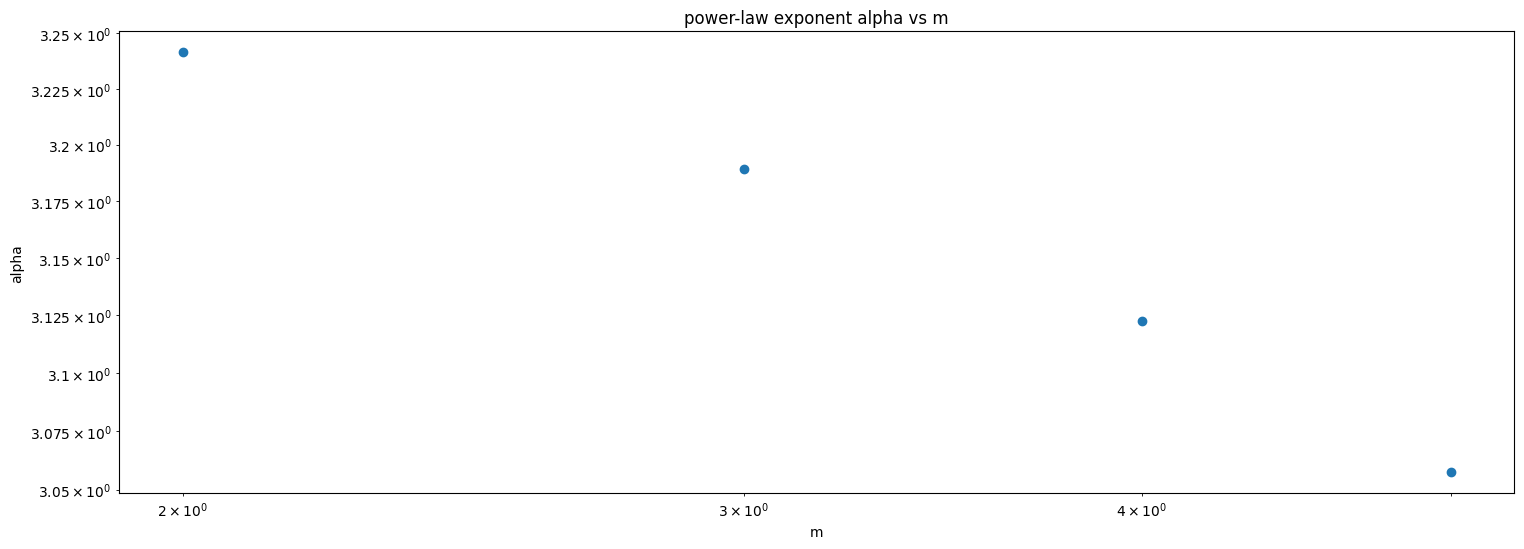

In [28]:
plt.scatter(m2,alpha_list)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('m')
plt.ylabel('alpha')
plt.title("power-law exponent alpha vs m")
plt.show()